In [1]:
!ls /kaggle/input/pyvips-python-and-deb-package-gpu
# intall the deb packages
!yes | dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package-gpu/linux_packages/archives/*.deb
# install the python wrapper
!pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package-gpu/python_packages/ --no-index
!pip list | grep pyvips


linux_packages	python_packages
Selecting previously unselected package apparmor.
(Reading database ... 114840 files and directories currently installed.)
Preparing to unpack .../apparmor_3.0.4-2ubuntu2.2_amd64.deb ...
Unpacking apparmor (3.0.4-2ubuntu2.2) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../autoconf_2.71-2_all.deb ...
Unpacking autoconf (2.71-2) ...
Selecting previously unselected package automake.
Preparing to unpack .../automake_13a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../autotools-dev_20220109.1_all.deb ...
Unpacking autotools-dev (20220109.1) ...
Selecting previously unselected package bzip2-doc.
Preparing to unpack .../bzip2-doc_1.0.8-5build1_all.deb ...
Unpacking bzip2-doc (1.0.8-5build1) ...
Selecting previously unselected package file.
Preparing to unpack .../file_13a5.41-3ubuntu0.1_amd64.deb ...
Unpacking file (1:5.41-3ubuntu0.1) ...
Sele

## Import Libraries

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pyvips
import warnings
import random
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tqdm import tqdm
from PIL import Image
from random import randrange

from pathlib import Path
from glob import glob

from skimage.exposure import is_low_contrast
from scipy.ndimage import zoom, rotate
from skimage.io import imread, imsave

from collections import defaultdict
from openslide import OpenSlide

random.seed = 19

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version: 2.13.0


In [3]:
data_path='../input/mayo-clinic-strip-ai/'
train_path = data_path + 'train/'
train_label_df = pd.read_csv(data_path + 'train.csv')
train_images_data = glob(train_path + "*")
print(f"Number of images in a training set: {len(train_images_data)}")

Number of images in a training set: 754


## Data Preprocessing Functions

In [4]:
def get_img_info(images_data, label_df):
    """
    Extract information about images and merge it with label information.

    Args:
    - images_data (list): List of paths to image files.
    - label_df (pandas.DataFrame): DataFrame containing label information.

    Returns:
    - pandas.DataFrame: Merged DataFrame containing image and label information.
    """
    img_prop = defaultdict(list)    
    for i, path in enumerate(images_data):

        img_path = images_data[i]
        slide = OpenSlide(img_path)    

        big_dim = 'none'
        max_min_dim_ratio = 1.0

        img_width = slide.dimensions[0]
        img_height = slide.dimensions[1]

        if(img_width > img_height):
            big_dim = 'width'
            max_min_dim_ratio = round(img_width/img_height, 2)
        elif(img_width < img_height):
            big_dim = 'height'
            max_min_dim_ratio = round(img_height/img_width, 2)

        img_prop['image_id'].append(img_path[-12:-4])
        img_prop['width'].append(img_width)
        img_prop['height'].append(img_height)
        img_prop['big_dim'].append(big_dim)
        #img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
        img_prop['max_min_dim_ratio'].append(max_min_dim_ratio)
        
        #if(max_min_dim_ratio < 2.0):
        #    split_size = round(max_min_dim_ratio)
        #else:
        #    split_size = math.floor(max_min_dim_ratio)
        split_size = round(max_min_dim_ratio)
        img_prop['split_size'].append(split_size)
        img_prop['path'].append(img_path)
        
        img_info = pd.DataFrame(img_prop)
        img_info.sort_values(by='image_id', inplace=True)
        img_info.reset_index(inplace=True, drop=True)
        img_info = img_info.merge(label_df, on='image_id')

    return img_info



In [5]:
def save_tile(path, name, vips_tile, label):
    """
    Save a tile image and display it.

    Args:
    - path (str): Path to save the tile images.
    - name (str): Name of the tile.
    - vips_tile (pyvips.Image): Tile image in pyvips format.
    - label (str): Label associated with the tile.

    Returns:
    - None
    """
    img = vips_tile.numpy()
    im = Image.fromarray(img)
    im.save(path + name + '_0.tif')
    plt.imshow(im)
    plt.title(f"Processed Image: {name}_0")
    plt.show()

    im_rotated_90 = im.rotate(90)
    im_rotated_90.save(path + name + '_1.tif')
    plt.imshow(im_rotated_90)
    plt.title(f"Processed Image: {name}_1 (Rotated 90 degrees)")
    plt.show()

    if label == 'LAA':
        im_rotated_135 = Image.fromarray(rotate(img, 135, reshape=False, mode='reflect'))
        im_rotated_135.save(path + name + '_2.tif')
        plt.imshow(im_rotated_135)
        plt.title(f"Processed Image: {name}_2 (Rotated 135 degrees)")
        plt.show()

        im_rotated_180 = im_rotated_90.rotate(90)
        im_rotated_180.save(path + name + '_3.tif')
        plt.imshow(im_rotated_180)
        plt.title(f"Processed Image: {name}_3 (Rotated 180 degrees)")
        plt.show()

        im_rotated_225 = Image.fromarray(rotate(img, 225, reshape=False, mode='reflect'))
        im_rotated_225.save(path + name + '_4.tif')
        plt.imshow(im_rotated_225)
        plt.title(f"Processed Image: {name}_4 (Rotated 225 degrees)")
        plt.show()

    print(name, 'done saving a tile...')


In [6]:
def split_save_tiles(row, last_img_index, path_tiles,IMG_SIZE = 224,IMG_CHANNELS = 3): 
    """
    Split an image into tiles, save them, and display the original and processed tiles.

    Args:
    - row (pandas.Series): Row from the DataFrame containing image information.
    - last_img_index (int): Index of the last processed image.
    - path_tiles (str): Path to save the tile images.
    - IMG_SIZE (int): Size of the thumbnail image (default: 224).
    - IMG_CHANNELS (int): Number of image channels (default: 3).

    Returns:
    - int: Updated index of the last processed image.
    """
    image_id = row['image_id']
    
    width = row['width']
    height = row['height']
    big_dim = row['big_dim']
    split_size = row['split_size']
    input_train_path = row['path']
    label = row['label']
    center_id = row['center_id']
    
    n_across = 1
    n_down = 1

    vips_img = pyvips.Image.new_from_file(input_train_path, access='sequential')
    plt.imshow(vips_img)
    plt.title(f"Original Image")
    plt.show()
    if(split_size == 1):
        crop_width = width
        crop_height = height
    elif(big_dim == 'width'):
        crop_width = width//split_size
        crop_height = height
        n_across = split_size
    else:
        crop_height = height//split_size
        crop_width = width
        n_down = split_size

    for x in range(n_across):
        for y in range(n_down):
            vips_tile = None
            if(split_size > 1):
                vips_tile = vips_img.crop(x*crop_width, y*crop_height, crop_width, crop_height)
            else:
                vips_tile = vips_img
                
            # Display the original tile
            plt.imshow(vips_tile)
            plt.title(f"Image Tile After Cropping: {image_id}_{x+y}")
            plt.show()
            print(last_img_index, image_id, 'processing image with splits(', split_size, ')' , crop_width, ' X ', crop_height)            
            vips_tile = vips_tile.thumbnail_image(IMG_SIZE, height=IMG_SIZE, size='force')
            if(is_low_contrast(vips_tile)):
                print('low contrast tile can not be saved ')
                continue
            tile_name = image_id + '_' + str(x+y)
            save_tile(path_tiles, tile_name, vips_tile, label)
            
            last_img_index += 1
    
    vips_img = None
    return last_img_index



## Apply Preprocessing on "LAA" Image

In [8]:
image_id_to_find = '00c058_0'
train_img_info = get_img_info(train_images_data, train_label_df)
single_row = train_img_info[train_img_info['image_id'] == image_id_to_find]
single_row


,image_id,width,height,big_dim,max_min_dim_ratio,split_size,path,center_id,patient_id,image_num,label
2,00c058_0,15255,61801,height,4.05,4,../input/mayo-clinic-strip-ai/train/00c058_0.tif,11,00c058,0,LAA


creating folder train/processed_image/
started processing image: 00c058_0


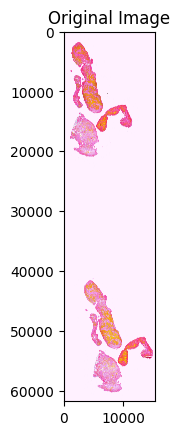

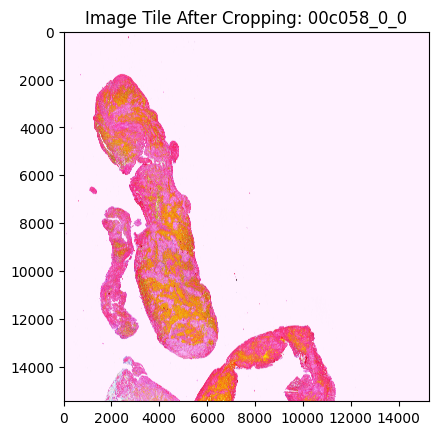

0 00c058_0 processing image with splits( 4 ) 15255  X  15450


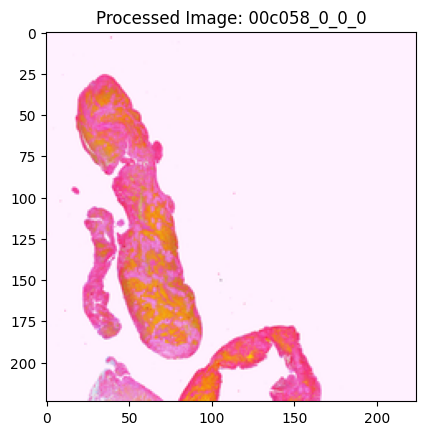

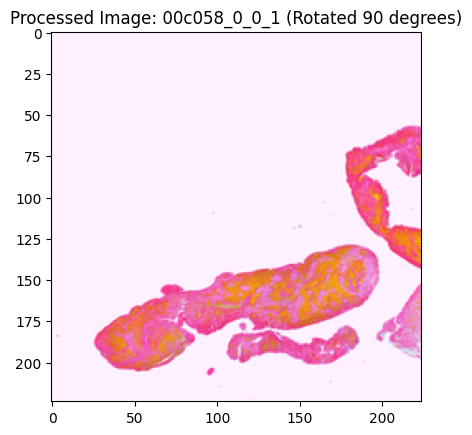

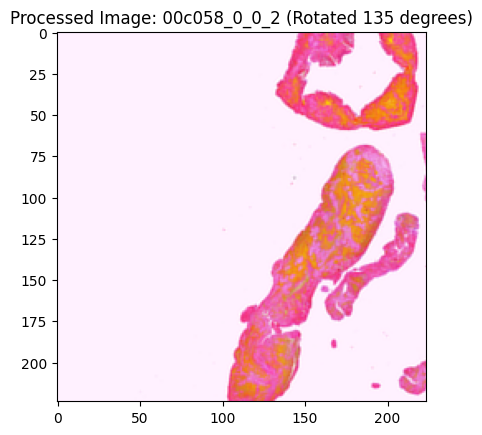

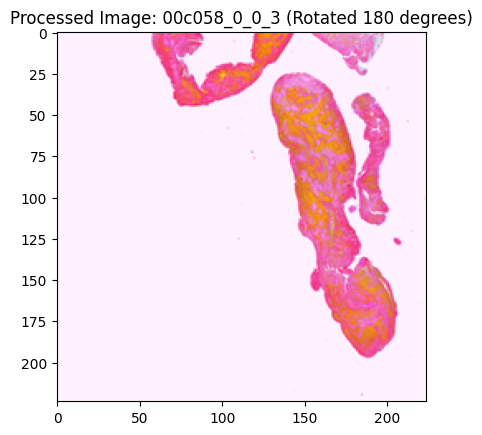

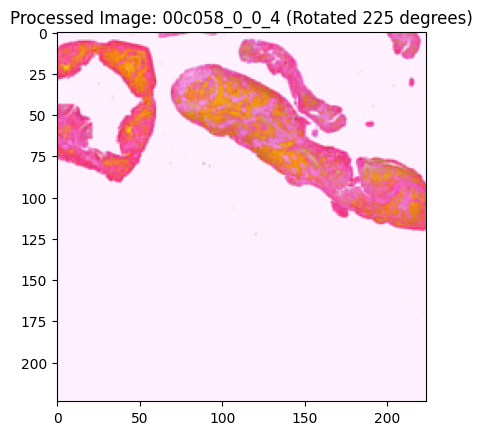

00c058_0_0 done saving a tile...


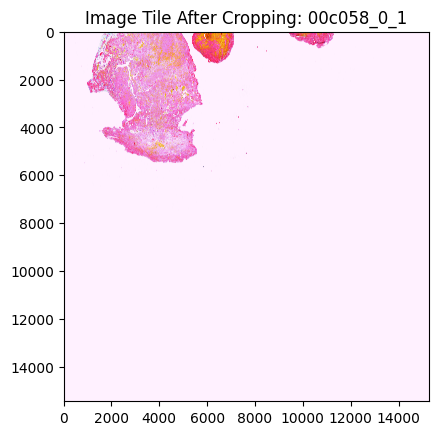

1 00c058_0 processing image with splits( 4 ) 15255  X  15450


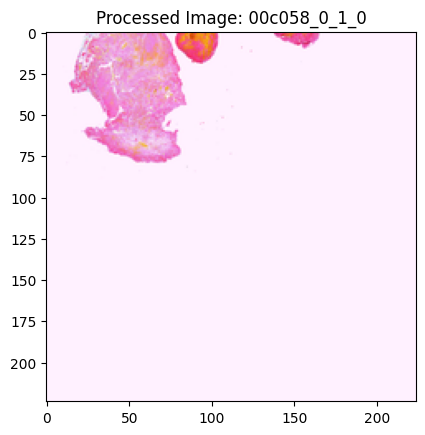

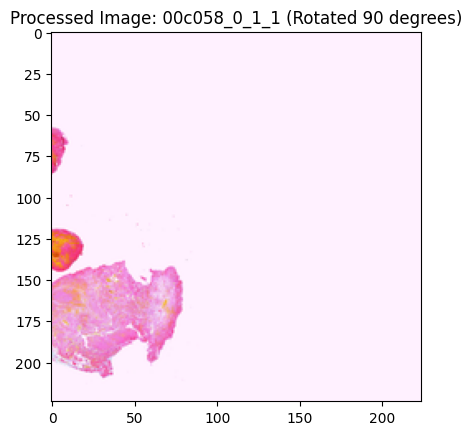

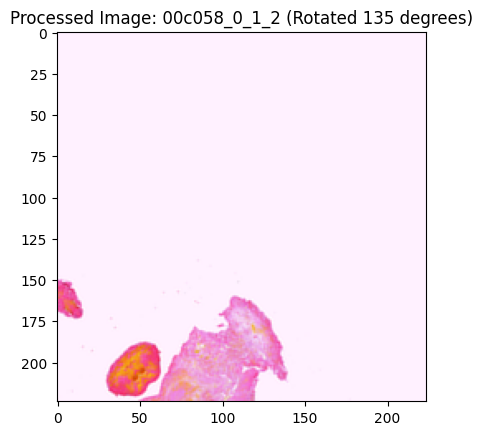

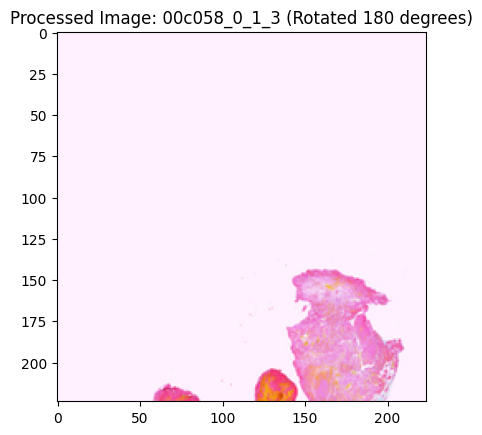

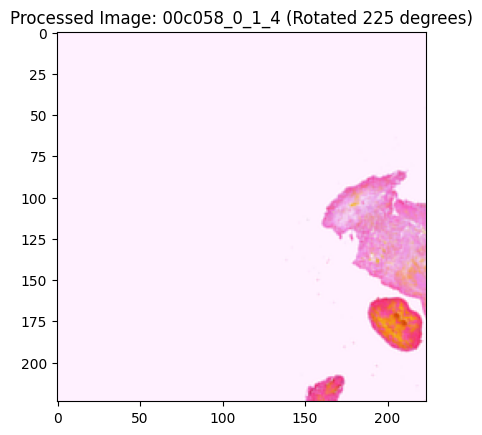

00c058_0_1 done saving a tile...


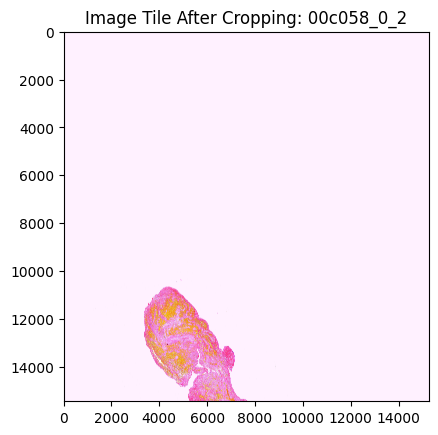

2 00c058_0 processing image with splits( 4 ) 15255  X  15450


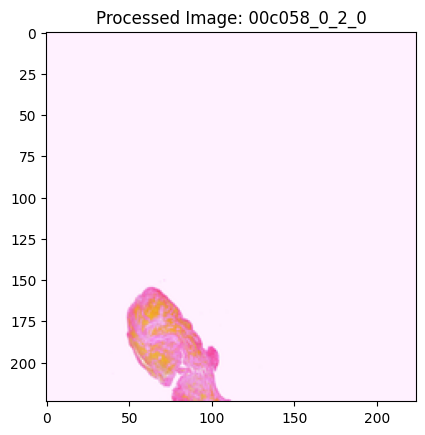

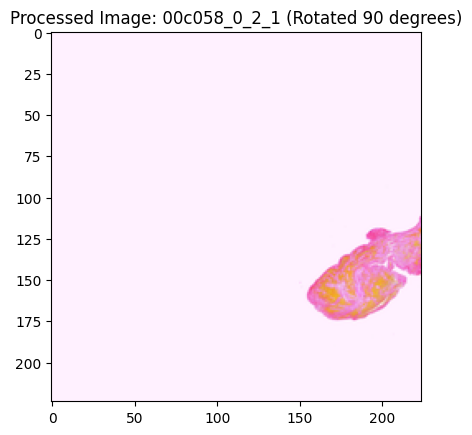

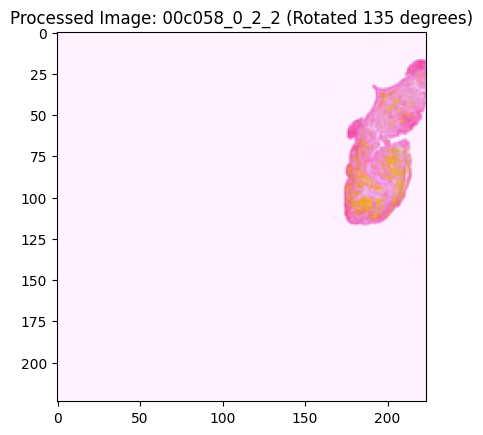

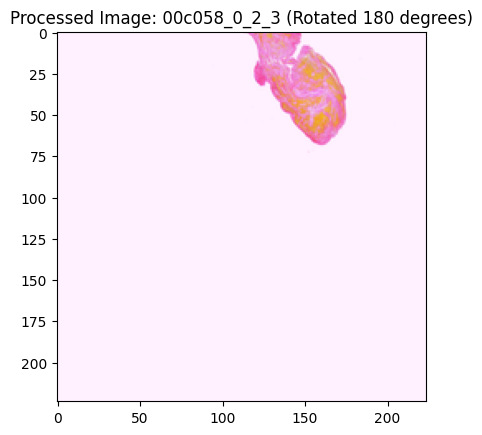

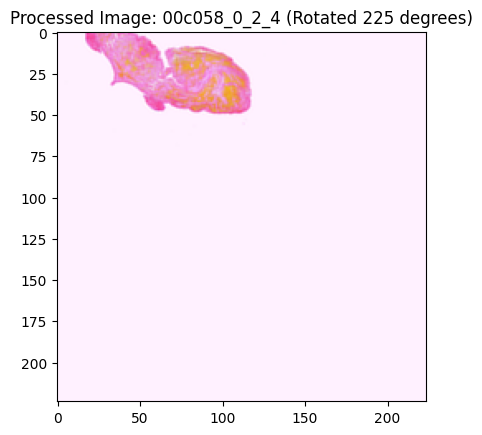

00c058_0_2 done saving a tile...


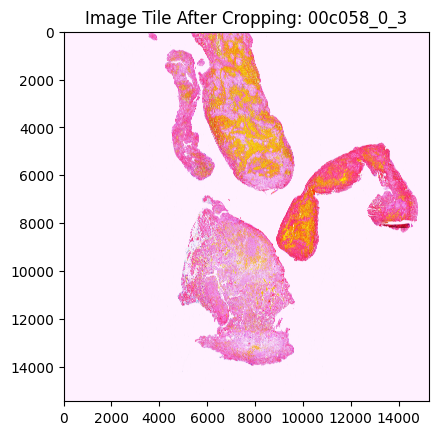

3 00c058_0 processing image with splits( 4 ) 15255  X  15450


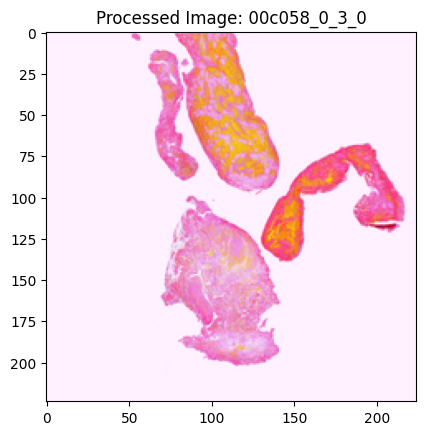

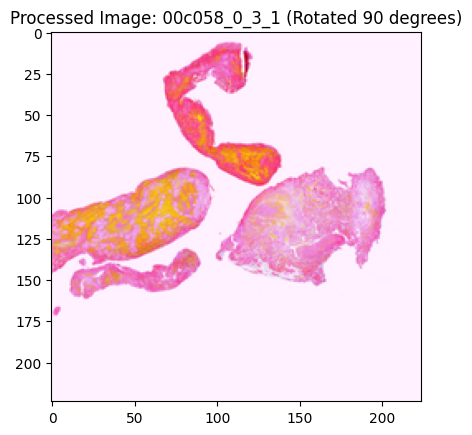

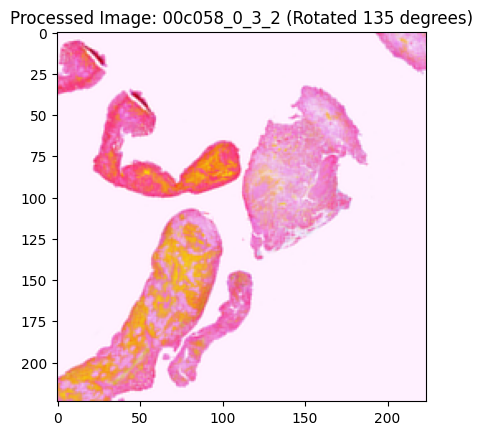

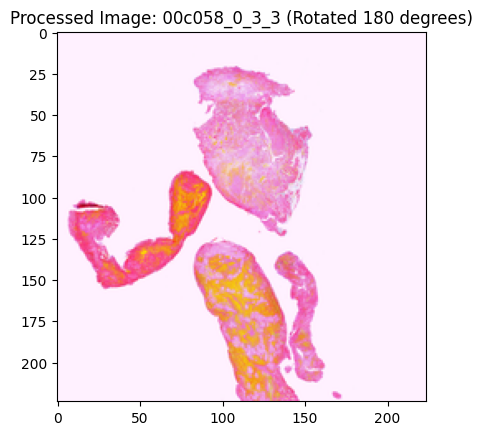

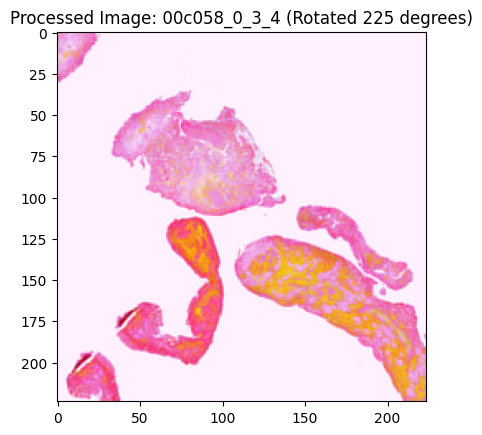

00c058_0_3 done saving a tile...
processed image: 00c058_0 Total processed tiles: 4


In [9]:
def process_single_tile(row, output_folder):
    exists_tiles = os.path.exists(output_folder)
    
    if not exists_tiles:
        print('creating folder', output_folder)
        os.makedirs(output_folder)

    last_img_index = 0
    print('started processing image:', row['image_id'])
    last_img_index = split_save_tiles(row, last_img_index, output_folder)
    print('processed image:', row['image_id'], 'Total processed tiles:', last_img_index)


train_img_info = get_img_info(train_images_data, train_label_df)
single_row = train_img_info.iloc[2]  
process_single_tile(single_row, 'train/processed_image/')
